In [33]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy 
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import xesmf as xe
import matplotlib.colors as colors

In [15]:
file = '/shared/scratch/jgaigala/asr15km.anl.2D.200001.mon.nc'

In [16]:
ds = xr.open_dataset(file)
ds = ds.rename({'XLONG': 'lon', 'XLAT': 'lat'})
var = 'SNOALB'
ds

<xarray.Dataset>
Dimensions:   (Time: 1, lev: 4, x: 720, y: 720)
Coordinates:
  * Time      (Time) datetime64[ns] 2000-01-16T11:00:00
    lat       (y, x) float32 ...
    lon       (y, x) float32 ...
  * lev       (lev) float64 1.0 2.0 3.0 4.0
Dimensions without coordinates: x, y
Data variables:
    DateTime  (Time) int32 ...
    ALBBCK    (Time, y, x) float32 ...
    ALBEDO    (Time, y, x) float32 ...
    ALBSI     (Time, y, x) float32 ...
    ICEDEPTH  (Time, y, x) float32 ...
    ISLTYP    (Time, y, x) int32 ...
    IVGTYP    (Time, y, x) int32 ...
    LAI       (Time, y, x) float32 ...
    LANDMASK  (Time, y, x) float32 ...
    LU_INDEX  (Time, y, x) float32 ...
    PMSL      (Time, y, x) float32 ...
    PSFC      (Time, y, x) float32 ...
    Q2M       (Time, y, x) float32 ...
    RH2M      (Time, y, x) float32 ...
    SEAICE    (Time, y, x) float32 ...
    SH2O      (Time, lev, y, x) float32 ...
    SKINTEMP  (Time, y, x) float32 ...
    SMOIS     (Time, lev, y, x) float32 ...
   

In [17]:
def regrid(var, lat_step=0.1, lon_step=0.1):
    # Create new lons and lats on a regular grid
    new_lat=np.arange(-90,90.1,lat_step)
    new_lon=np.arange(0,360.1,lon_step)

    # Create an xarray.Dataset that defines the new grid
    ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                    'lon': (['lon'], new_lon)})
    
    # Regrid the data to the new grid 
    regridder = xe.Regridder(ds, ds_out, 'bilinear', reuse_weights=True)
    dr = regridder(ds[var]).to_dataset(name=var)
    
    return dr

In [20]:
dr = regrid('SH2O').squeeze()
dr

Reuse existing file: bilinear_720x720_1801x3601.nc


<xarray.Dataset>
Dimensions:  (Time: 1, lat: 1801, lev: 4, lon: 3601)
Coordinates:
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0
  * lat      (lat) float64 -90.0 -89.9 -89.8 -89.7 -89.6 ... 89.7 89.8 89.9 90.0
  * Time     (Time) datetime64[ns] 2000-01-16T11:00:00
  * lev      (lev) float64 1.0 2.0 3.0 4.0
Data variables:
    SH2O     (Time, lev, lat, lon) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0

In [38]:
mask_file='/shared/obs/gridded/OISSTv2/lmask/lsmask.nc'
ds_mask=xr.open_dataset(mask_file)
ds_mask=ds_mask.squeeze() # drop empty time dimension from data variables
ds_mask=ds_mask.reindex(lat=list(reversed(ds_mask['lat'])))
ds_mask
da_mask = ds_mask['mask'].squeeze()

In [36]:
dr

<xarray.Dataset>
Dimensions:  (lat: 1801, lev: 4, lon: 3601)
Coordinates:
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9 360.0
  * lat      (lat) float64 -90.0 -89.9 -89.8 -89.7 -89.6 ... 89.7 89.8 89.9 90.0
    Time     datetime64[ns] 2000-01-16T11:00:00
  * lev      (lev) float64 1.0 2.0 3.0 4.0
Data variables:
    SH2O     (lev, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0

## Map regridded ASR 15km SNOALB

Text(0.5, 1.0, 'SOIL H20')

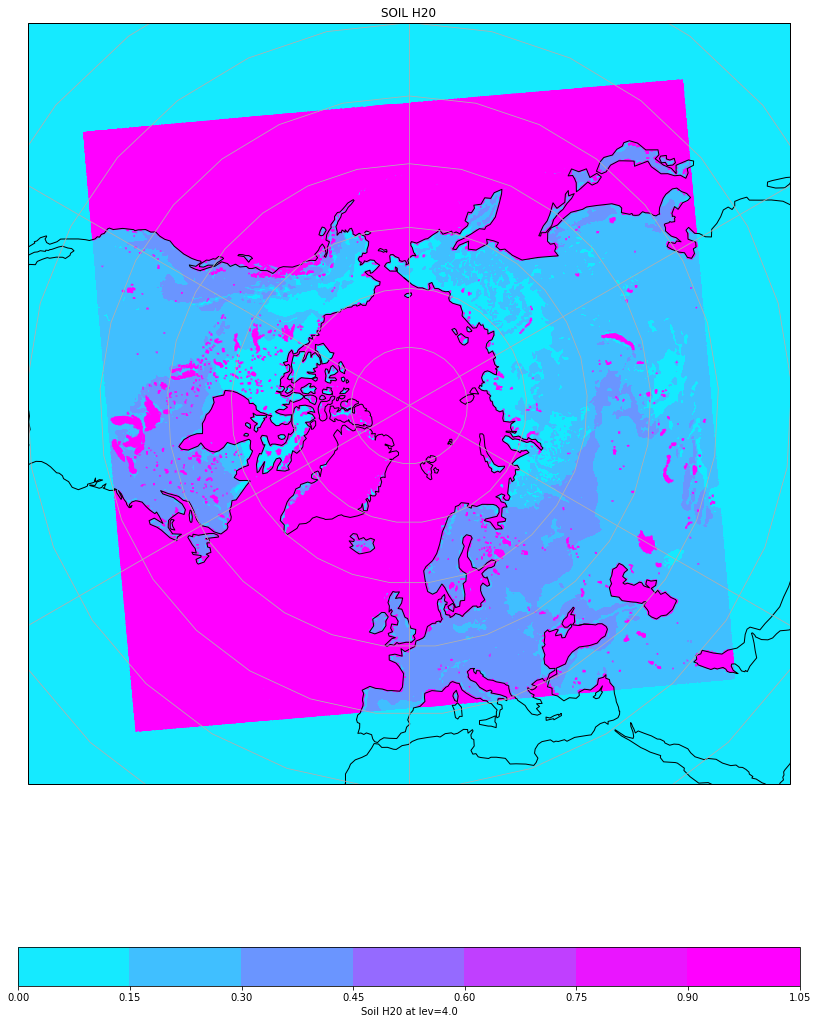

In [43]:
levels = reversed([0.05, 0.25, 0.7, 1.25])

fig = plt.figure(figsize=(20,20))

# specify axis map projection
ax=plt.axes(projection=ccrs.NorthPolarStereo())


# make a filled contour plot
cs=ax.contourf(dr['lon'], dr['lat'], 
            dr['SH2O'].sel(lev=4.0).dropna(dim='lat').dropna(dim='lon'), 
            transform=ccrs.PlateCarree(),
            cmap='cool',
            vmin=0.0,
            vmax=0.9)

ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())

# add reference lines
ax.coastlines()
ax.gridlines()

cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,label='Soil H20 at lev=4.0')

plt.title('SOIL H20')

Text(0.5, 0.98, 'ARSv2 2000 January Soil Liquid Water')

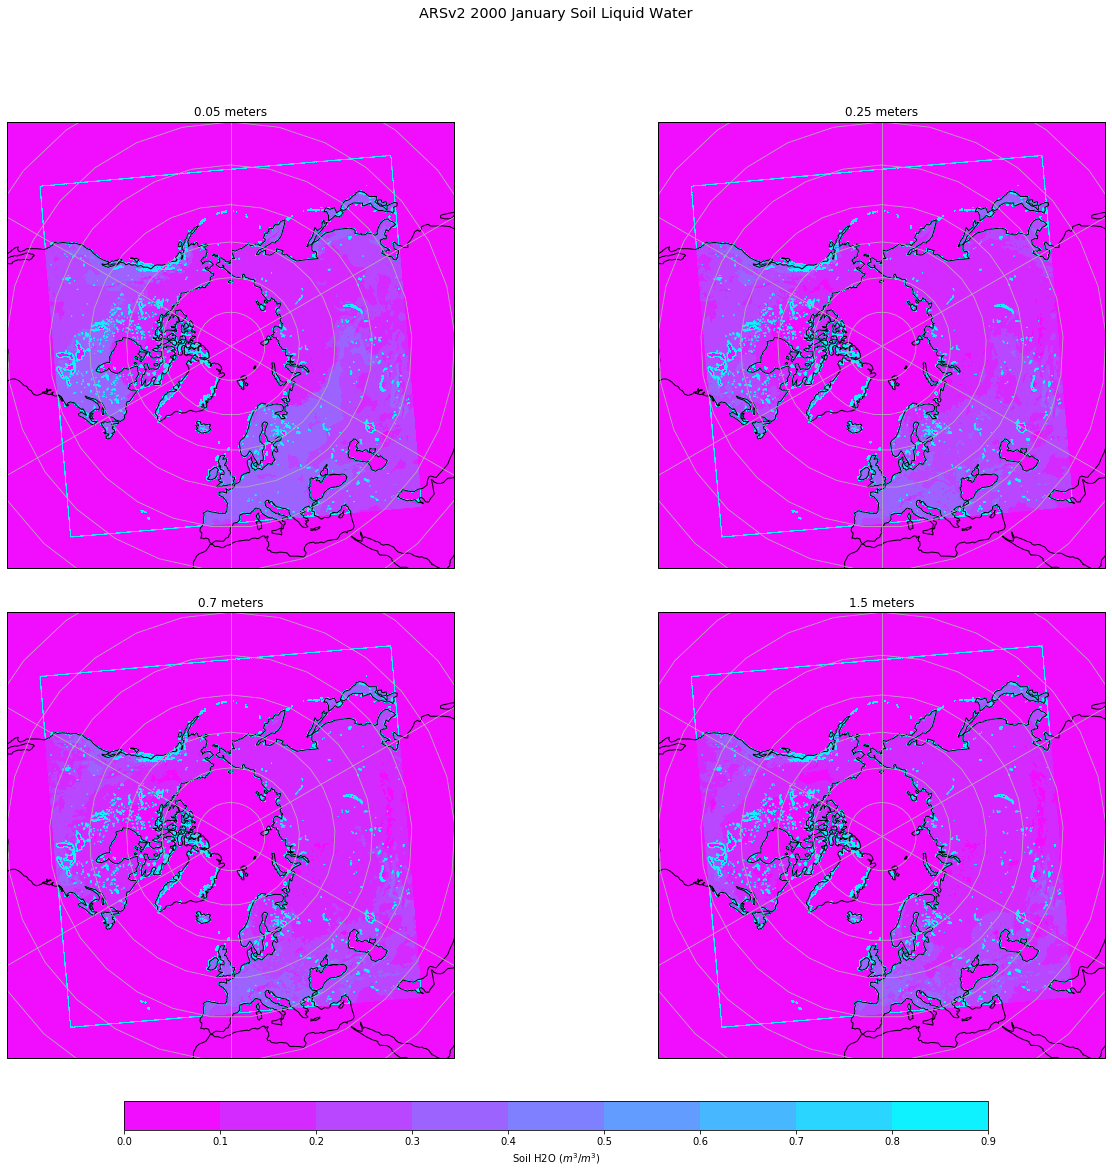

In [48]:
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(20,20))
axs=axs.flatten()

clevs=np.arange(0.0,1.0, 0.1)

for lev, depth in [(4.0,0.05), (3.0,0.25), (2.0,0.7), (1.0, 1.5)]:
    ax = axs[int(4-lev)]
    
    cs=ax.contourf(dr['lon'], dr['lat'], 
            dr['SH2O'].sel(lev=lev), clevs,
            transform=ccrs.PlateCarree(),
            cmap='cool_r')
    ax.set_extent([-180, 180, 30, 90], ccrs.PlateCarree())

    # add reference lines
    ax.coastlines()
    ax.gridlines()
    
    ax.set_title(f"{depth} meters")

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.01, hspace=0.1)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Soil H2O $(m^3/m^3)$')

# Add a big title at the top
plt.suptitle('ARSv2 2000 January Soil Liquid Water', size='x-large')